In [1]:
import relational_image_generation_evaluation as rige

In [2]:
evaluator = rige.Evaluator('ViT-L/14-Datacomp')
dataloader_one = rige.get_one_edge_dataloader(testonly=True)
dataloader_two = rige.get_two_edge_dataloader(testonly=True)
dataloader_full = rige.get_full_graph_dataloader(testonly=True)
dataloader_mscoco = rige.get_mscoco_graph_dataloader(testonly=False)
print("len(dataloader_one):", len(dataloader_one))
print("len(dataloader_two):", len(dataloader_two))
print("len(dataloader_mscoco)", len(dataloader_mscoco))

Using device cuda:2 for evaluation.


Using text embeddings as input to the model.
Loading filtered test graphs...
Finished loading filtered test graphs
Generating one edge graphs...


100%|██████████| 100/100 [00:00<00:00, 1023.63it/s]


Finished generating one edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
Generating two edge graphs...


100%|██████████| 100/100 [00:00<00:00, 232.70it/s]


Finished generating two edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs


Downloading...
From: https://drive.google.com/uc?id=1Mu6dFN-5RsvA1pqIimgaHBJT1xeugEpa
To: /local/home/jthomm/GraphCLIP/relational_image_generation_evaluation/relational_image_generation_evaluation/data/mscoco_graphs.pt
100%|██████████| 12.4M/12.4M [00:00<00:00, 42.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MFLheYOGBC7Y-zHEv_o37ByyjdlBGy_s
To: /local/home/jthomm/GraphCLIP/relational_image_generation_evaluation/relational_image_generation_evaluation/data/mscoco_graphs_test_small.pt
100%|██████████| 55.0k/55.0k [00:00<00:00, 33.6MB/s]


Loading mscoco graphs...
Finished loading mscoco graphs
len(dataloader_one): 837
len(dataloader_two): 1076
len(dataloader_mscoco) 2163


Caption:vase with flowers.


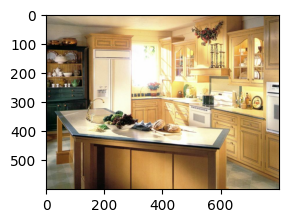

Caption:glass table has glass.


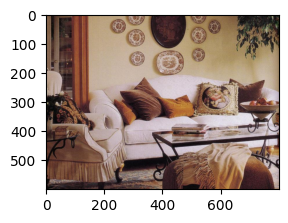

Caption:square window on building.


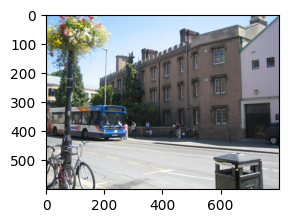

Caption:black tire on green, blue, shiny car.


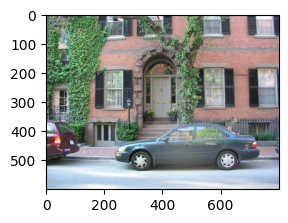

Caption:people at circular table.


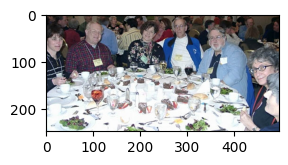

Caption:person sitting on train.


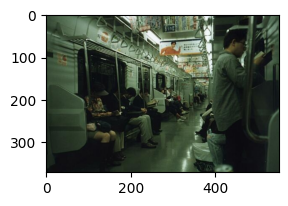

Caption:walking man has red bag.


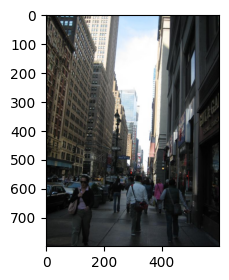

Caption:glass on table.


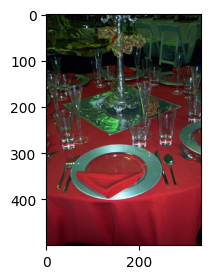

Caption:door on red, brick building.


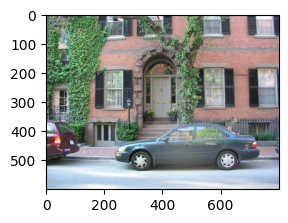

Caption:car on top of street.


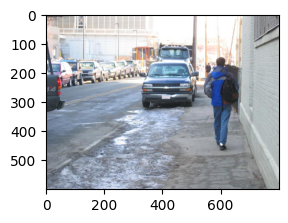

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_one))[0]
    print("Caption:" + graph.caption)
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # small figure size to fit in the notebook
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    images.append(image)
    graphs.append(graph)

In [4]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.6945450901985168, 0.9528504014015198, 0.9871371984481812, 0.05328739434480667, 0.19201719760894775, 0.9736858010292053, 0.013105825521051884, 0.9981375932693481, 0.011661670170724392, 0.37652158737182617], 'attr_scores': ['noattributes', 0.9241141080856323, 0.5862787961959839, 0.35320526361465454, 0.000765046919696033, 'noattributes', 0.4331836700439453, 'noattributes', 0.8040107488632202, 'noattributes']}
dict_keys(['rel_scores', 'attr_scores'])


In [5]:
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_two))[0]
    assert len(graph.edges) == 2, f"Graph does not have two edges: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images.append(image)
    graphs.append(graph)

In [6]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9839267134666443, 0.9842110872268677, 0.9603124856948853, 0.9670870304107666, 0.9007983207702637, 0.4717627763748169, 0.9875704646110535, 0.4192347824573517, 0.7031576633453369, 0.9128290414810181], 'attr_scores': ['noattributes', 0.3004956841468811, 0.2872288227081299, 0.24860869348049164, 0.629729688167572, 0.26427629590034485, 'noattributes', 0.6687688231468201, 'noattributes', 0.5627623200416565]}
dict_keys(['rel_scores', 'attr_scores'])


In [7]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for i in range(300):
    graph = next(iter(dataloader_one))[0]
    assert len(graph.edges) == 1, f"Graph does not have one edge: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image_orig = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    image_adv = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
print(scores_orig['attr_scores'])
print(scores_adv['attr_scores'])

['noattributes', 0.4038930833339691, 0.34000304341316223, 'noattributes', 'noattributes', 0.49560821056365967, 0.6687696576118469, 'noattributes', 0.26091229915618896, 0.7256128787994385, 0.45577579736709595, 'noattributes', 0.23195184767246246, 0.6983509063720703, 'noattributes', 0.698350727558136, 0.7514296770095825, 0.02600022405385971, 0.5323565006256104, 0.2779780626296997, 'noattributes', 'noattributes', 0.3348170518875122, 0.32489603757858276, 0.04191867634654045, 0.34666740894317627, 'noattributes', 0.09917963296175003, 0.5026042461395264, 'noattributes', 0.5526729226112366, 0.5060549378395081, 'noattributes', 'noattributes', 0.031772155314683914, 'noattributes', 'noattributes', 0.1133190244436264, 0.009956445544958115, 'noattributes', 0.9745047688484192, 0.11902481317520142, 0.001042969524860382, 0.12137679010629654, 0.01459724921733141, 0.5143182873725891, 0.5008362531661987, 0.03177215903997421, 'noattributes', 'noattributes', 0.49683260917663574, 0.000724100274965167, 0.285

In [8]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
for orig,adv in zip(scores_orig['attr_scores'],scores_adv['attr_scores']):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

warning, this is unlikely to happen
n_correct: 172.5, n_incorrect: 25, accuracy: 0.8734177215189873


### MSCOCO Graphs

Caption:Bathroom scene: pink, empty toilet paper in blue trash can; wet toilet paper on floor; stained, dirty toilet bowl and tank; person wearing gray jacket and sandals standing on cream-colored tiles; red basket and blue trash bag next to red wastebasket; 2 trash cans (red and pink); metal handle and plastic soap dispenser; dirty toilet lid.


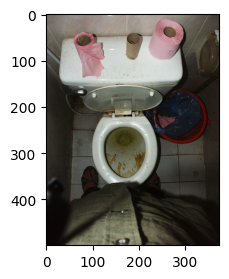

Caption:A German-made train with tankers and white letters on it is next to a weathered cobblestone platform. A person is inside the train that has a huge window with a wiper. There are power lines over the train and a signal board, street lights, and gravel nearby. The train has a mechanism, a panel with words on it, and four sections.


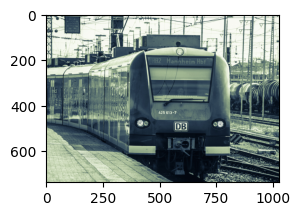

Caption:A red stop sign and an Octagon ON a plain Sign. An On light, white text, and a tall Light. Another stop sign and three signs, one white and one Octagon. A plain street sign atop another stop sign with no text. A test node.


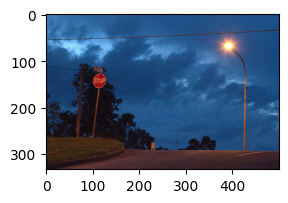

Caption:Four people in the picture, one wearing a tank top. Two men wear pants, one long and one short. Banana bunch is shown, one labeled "sweet". One of the men wearing pants has long sleeves is also wearing a tank top. A "sweet banana" is labeled in group.


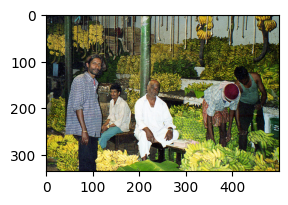

Caption:A man in brown shirt and blue jeans holds blue umbrella next to a large green tree, holding another umbrella. Black pipe on wall connects to bridge. White house and calm river with green grass and walkway. The river has tall trees, blue water with reflection, beside hills and wall. Objects include old cement rail, shoe, head, hand, red object.


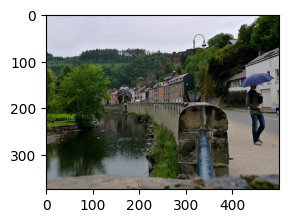

Caption:A man with long hair in black trunks surfs wild water, next to another man on a white surfboard. A blue-finned surfer rides a board on a calm ocean. Spray surrounds a black and white board. A hairy-legged man balances on a black-decaled board. All against a distant sky and blue ocean.


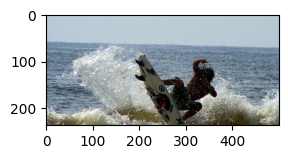

Caption:A smiling woman stands next to a pond.


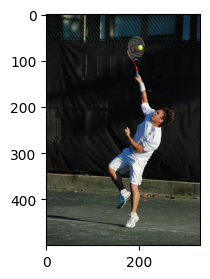

Caption:A woman carries umbrella, wears black sunglasses, has pearl necklace and black purse. Another woman wears sunglasses, carries white umbrella and has black shirt with hairy legs. Man wears cap, shorts and carries large cup. A brown bear is nearby. Objects include: shoes, socks, handle, support, white umbrella, black watch, pocketbook, and blue sign.


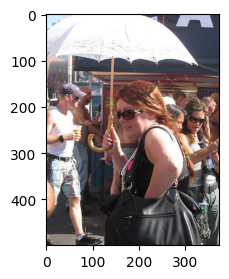

Caption:A man stands in a room wearing a black suit with a name tag. He has crossed hands and a smiling face. The room has a computer desk with a monitor, keyboard, mouse and cables. The monitor is lit and reflected in a one-way glass. The room has a wooden table, chairs behind one-way glass and a window.


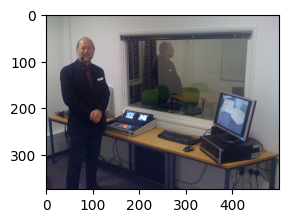

Caption:A man in a cap and blue striped shirt watches a biker in blue uniform lead the race. A yellow flag with a black lion waves. The concrete ground has green lines; a metal bar is nearby. Water is in the background. A pink-shirted woman and white-shoed person watch. Helmets and a blue bike are present, along with other objects.


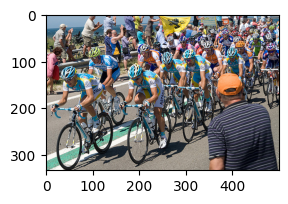

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_mscoco))[0]
    print("Caption:" + graph.caption)
    image_id = graph.image_id
    path ='/home/robert/g/GraphCLIP/datasets/visual_genome/raw/VG_100K/' + str(image_id) + '.jpg'
    if not os.path.exists(path):
        path = '/home/robert/g/GraphCLIP/datasets/visual_genome/raw/VG_100K_2/' + str(image_id) + '.jpg'
    image = Image.open(path)
    # small figure size to fit in the notebook
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    images.append(image)
    graphs.append(graph)

# Check the adversarial datasets prompt generation

In [1]:
import relational_image_generation_evaluation as rige
# evaluator = rige.Evaluator('ViT-L/14')
evaluator = rige.Evaluator('ViT-B/32')

Using device cuda:0 for evaluation.


In [1]:
import relational_image_generation_evaluation as rige
rel_orig, rel_adv = rige.get_adv_prompt_list('relationships')
attr_orig, attr_adv = rige.get_adv_prompt_list('attributes')
print(rel_orig)
# save the prompts to a file where each line is a prompt
with open('rel_orig.txt', 'w') as f:
    for item in rel_orig:
        f.write("%s\n" % item)
print(rel_adv)
# save the prompts to a file where each line is a prompt
with open('rel_adv.txt', 'w') as f:
    for item in rel_adv:
        f.write("%s\n" % item)
print(attr_orig)
# save the prompts to a file where each line is a prompt
with open('attr_orig.txt', 'w') as f:
    for item in attr_orig:
        f.write("%s\n" % item)
print(attr_adv)
# save the prompts to a file where each line is a prompt
with open('attr_adv.txt', 'w') as f:
    for item in attr_adv:
        f.write("%s\n" % item)

['man walking on sidewalk.', 'man walking on sidewalk.', 'book on table.', 'man on sidewalk.', 'man on sidewalk.', 'man sitting at desk.', 'cup on desk.', 'cup on desk.', 'bottle on table.', 'bottle on table.', 'bottle on table.', 'bottle on table.', 'person sitting in car.', 'sign next to road.', 'bike next to car.', 'bike next to car.', 'sign next to road.', 'door on cabinet.', 'laptop on desk.', 'laptop on desk.', 'flowers on table.', 'book on shelf.', 'book on shelf.', 'pillow on bed.', 'book on shelf.', 'vase in front of lamp.', 'wall behind lamp.', 'flowers in vase.', 'bowl on table.', 'box under desk.', 'cup on desk.', 'box under desk.', 'hat on head.', 'box on top of desk.', 'shelf on desk.', 'bird on branch.', 'car on road.', 'building next to tower.', 'building next to tower.', 'tower on building.', 'handle on cup.', 'man on bed.', 'man on bed.', 'tree behind giraffe.', 'tie on man.', 'man sitting at table.', 'trees behind field.', 'trees behind cow.', 'trees behind cow.', 't